<a href="https://colab.research.google.com/github/Zach-Seymour/FDSFE_ZSeymour/blob/main/HW9/Copy_of_EthicsAIaenc_faces_FDSFE23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for EthicsAI2021

# Autoencoder notebook
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


In [4]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
from tqdm import tqdm_notebook as tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:

cd /content/gdrive/Shareddrives/FDSFE23


/content/gdrive/Shareddrives/FDSFE23


In [6]:
ls

 Ademidun-headshot.JPG       cropped-IMG_7248.jpg    'headshot (2).jpeg'   imgreconstruct_10000.h5
 Bianco-headshot.jpg         data/                    headshot.jpeg        landscape_plot.png
'cropped-IMG_7248 (1).jpg'  'headshot (1) (1).jpeg'   Himal/               Muhideen-headshot.jpg
'cropped-IMG_7248 (2).jpg'  'headshot (1).jpeg'       IMG_1817.jpeg        portrait_plot.png


# 1A load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [ ]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


In [ ]:
#!unzip faces95.zip

In [ ]:
#flist = glob.glob("FDSFE2023/faces95/*/*jpg")

In [ ]:
# DO NOT RUN
N = len(flist)
N

1140


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

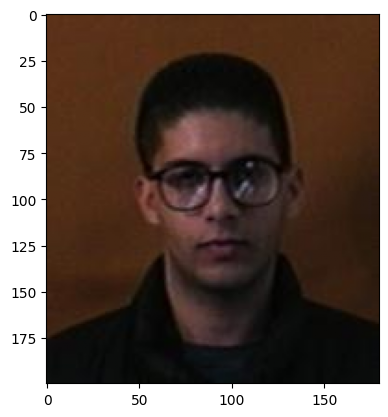

In [ ]:
# DO NOT RUN
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

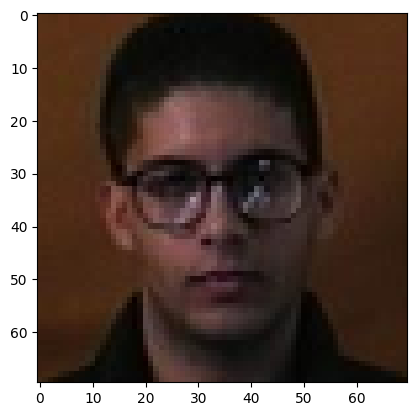

In [ ]:
# DO NOT RUN
pl.imshow(np_im[25:165:2,25:165:2])

<font color='red'>you can skip this and go  straight to loading the images</font>

In [ ]:
# DO NOT RUN
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i in tqdm(range(len(flist))):
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255
  # here I collect the certain portion of each image
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

In [ ]:
#np.save("data/faces_saved.npy", imgs)

# 1B you can read the images below if you have saved them earlier

In [7]:
#RUN ME
imgs = np.load("data/faces_saved.npy")
imgs.shape

(1140, 70, 70, 1)

## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command
          train_test_split(input, target, test_size = .25, random_state=1)
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)

## Meet me at the enf of that to create the autoencoder.

In [8]:
#RUN ME
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [8]:
imgs_orig.shape

(1140, 70, 70, 1)

In [9]:
#RUN ME
# lower the resolution
# imgs_lr = imgs[:,::2,::2]
# slightly better than the line of code above
imgs_lr = imgs.reshape(imgs.shape[0], int(imgs.shape[1]/2), 2,
                        int(imgs.shape[2]/2), 2
                       ).mean(axis=-1).mean(axis=2)
imgs_lr.shape

(1140, 35, 35)

In [10]:
#this is the number of pixels in the image
print("Number of pixels: original: ", np.prod(imgs[1].shape), "new size: ", np.prod(imgs_lr[1].shape))

Number of pixels: original:  4900 new size:  1225


#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [11]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs_orig,
                                             test_size = .20, random_state=1)

In [12]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((912, 35, 35), (228, 35, 35), (912, 70, 70, 1), (228, 70, 70, 1))

In [13]:
#each image needs to be unravel into a flat array
X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [14]:
## important: we feed to the NN rows of pixels, not cubes of pixels
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((912, 1225), (228, 1225), (912, 4900), (228, 4900))

## 3 build an autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [15]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)
model = Sequential()
model.add(Dense(256, activation = 'relu',input_dim=1225)) #encoder
model.add(Dense(128, activation = 'relu',name='bottleneck'))#bottleneck
model.add(Dense(256, activation = 'relu')) #decoder
model.add(Dense(1225, activation = 'relu'))#decoder
model.add(Dense(1225*4, activation = 'sigmoid'))#decoder




In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               313856    
                                                                 
 bottleneck (Dense)          (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1225)              314825    
                                                                 
 dense_3 (Dense)             (None, 4900)              6007400   
                                                                 
Total params: 6702001 (25.57 MB)
Trainable params: 6702001 (25.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [16]:
model.compile(optimizer = 'adamax',loss = 'mse',
              metrics = ['mae','acc'])

In [ ]:
# DO NOT RUN - use this for comparison
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               313856    
                                                                 
 bottleneck (Dense)          (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 1225)              314825    
                                                                 
 dense_3 (Dense)             (None, 4900)              6007400   
                                                                 
Total params: 6702001 (25.57 MB)
Trainable params: 6702001 (25.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [17]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=0.0001)

In [ ]:
# DO NOT RUN
## you can skip this and load the saved model
history = model.fit( X_tr, y_tr, epochs=100000,
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])


Epoch 1/100000


KeyboardInterrupt: ignored

In [ ]:
#model.save("data/imgreconstruct_10000.h5")

In [18]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5 - if you do not have access to the shared drive
model.load_weights("data/imgreconstruct_10000.h5")

## predict

In [19]:
outim = model.predict(X_te)
outim

8/8 [==============================] - 1s 2ms/step


array([[0.28861234, 0.29733795, 0.30639136, ..., 0.2600948 , 0.23321056,
        0.23846814],
       [0.22360253, 0.2155797 , 0.21935272, ..., 0.18229483, 0.17112018,
        0.18033509],
       [0.25289035, 0.23826672, 0.24279073, ..., 0.13537833, 0.12746254,
        0.13771334],
       ...,
       [0.28094912, 0.28029388, 0.27561685, ..., 0.08949736, 0.09429087,
        0.09027921],
       [0.31490386, 0.27540493, 0.29921466, ..., 0.19649698, 0.17643747,
        0.16256334],
       [0.26780328, 0.26125705, 0.2568325 , ..., 0.13951032, 0.14736353,
        0.1424112 ]], dtype=float32)

In [20]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''

  fig = pl.figure(figsize(10,5))

  ax = fig.add_subplot(131)
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = fig.add_subplot(132)
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = fig.add_subplot(133)
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


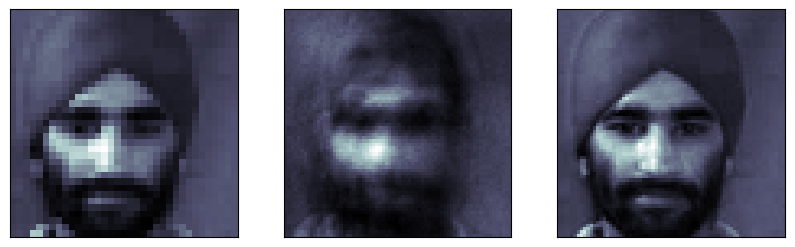

2 :	input		      prediction		  target


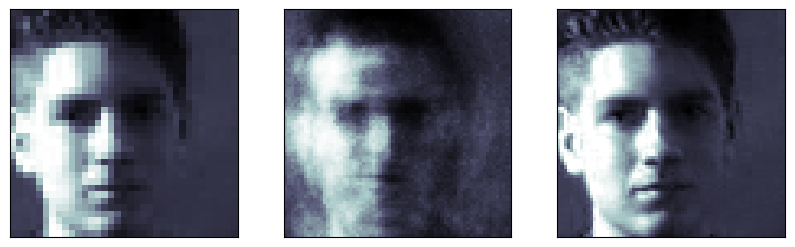

3 :	input		      prediction		  target


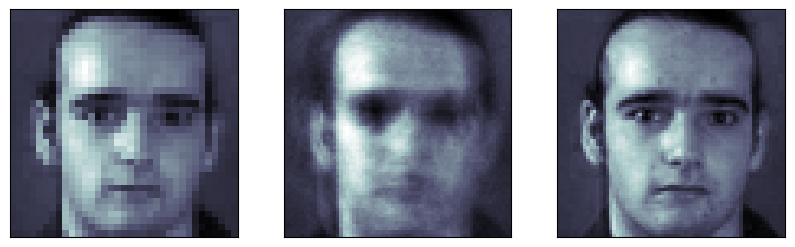

4 :	input		      prediction		  target


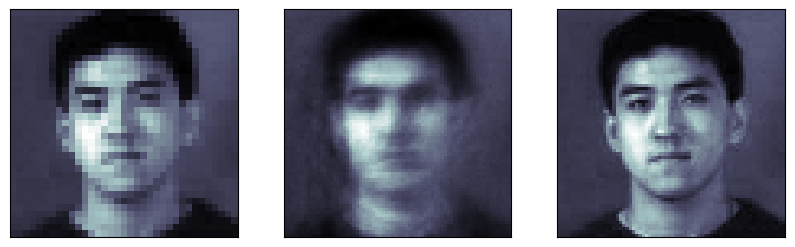

5 :	input		      prediction		  target


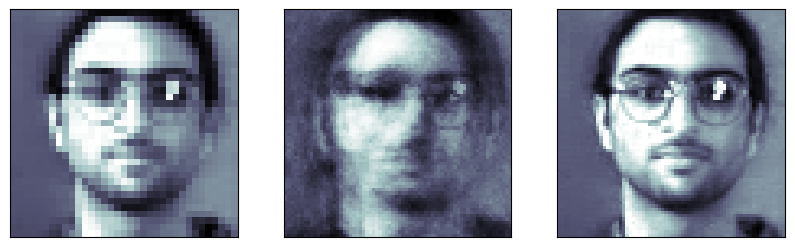

6 :	input		      prediction		  target


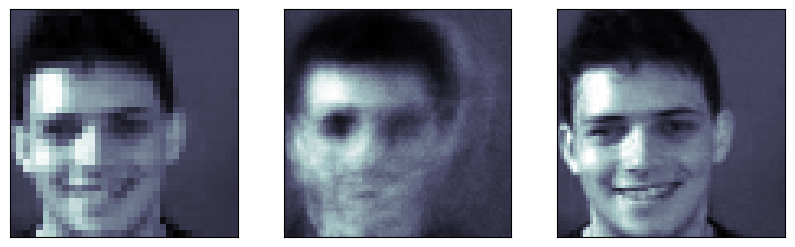

7 :	input		      prediction		  target


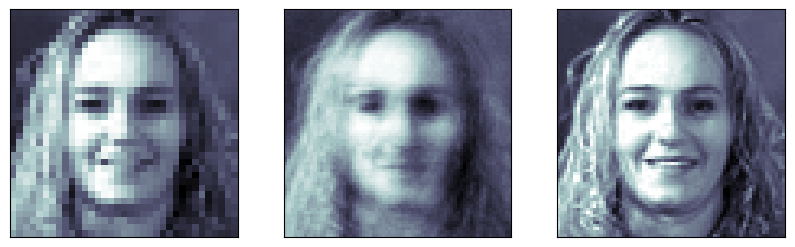

8 :	input		      prediction		  target


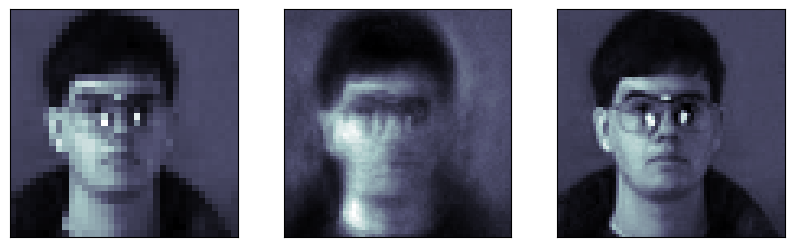

9 :	input		      prediction		  target


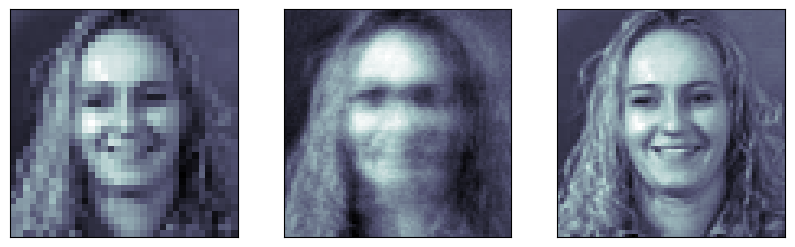

10 :	input		      prediction		  target


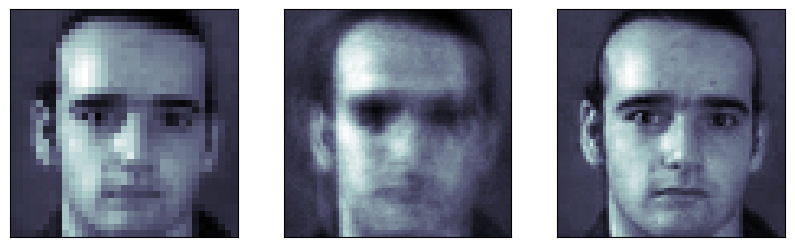

In [21]:
np.random.seed(925600)
# pick a few random test images
for i in range(0, 10, 1):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

## show the latent representation of the data: the bottleneck layer output

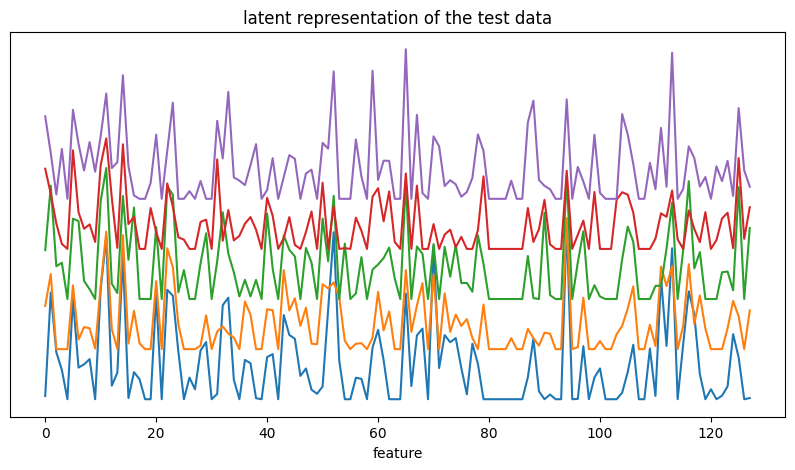

In [22]:
from keras import backend as K
# input placeholder
inp = model.input
# extract the bottle neck outputs
outputs = model.layers[1].output
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])

# Testing
layer_outs = functors(X_te[:5])

for i in range(5):
  pl.plot(layer_outs[0][i] + i)

pl.xlabel("feature")
pl.yticks([],"")
pl.title("latent representation of the test data");

Caption: Each value in each series represents the value of an autoencoder latent space feature. Each series represents a different object in the dataset.

# test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [23]:
from google.colab import files
from io import BytesIO
from PIL import Image
uploaded = files.upload()


Saving IMG_1817.jpeg to IMG_1817 (1).jpeg


In [24]:
file_contents = uploaded[list(uploaded.keys())[0]]


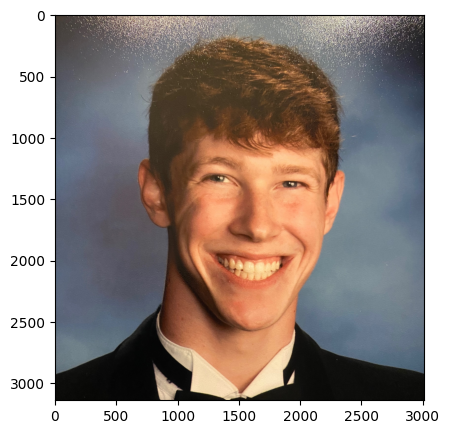

In [25]:
imme = Image.open(BytesIO(file_contents))
plt.imshow(imme)

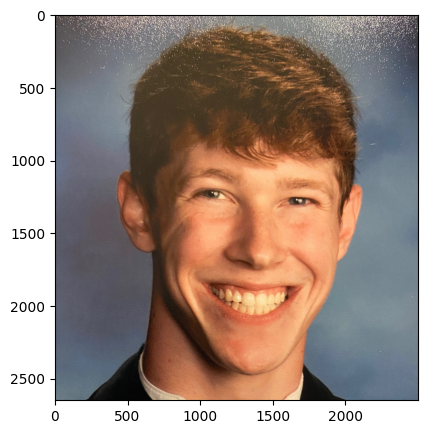

In [30]:
np_im = numpy.array(imme)[100:2750,250:2750,:3].astype(float) / 255
pl.figure()
pl.imshow(np_im )

In [28]:
np_im.shape

(2650, 2500, 3)

In [31]:
np_im.shape

(2650, 2500, 3)

low resolution version
subsampling by 15

In [44]:
np_im_me = np_im[::77,::73,:1]
np_im_me.shape

(35, 35, 1)

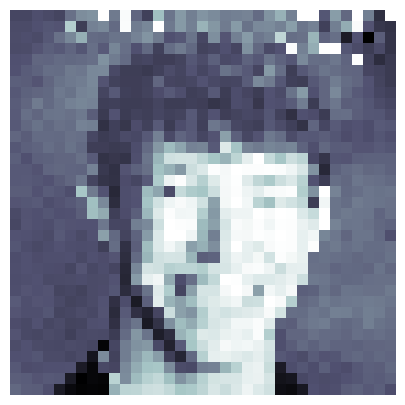

In [45]:

pl.imshow(np_im_me, cmap="bone")
pl.axis('off');

1/1 [==============================] - 0s 24ms/step


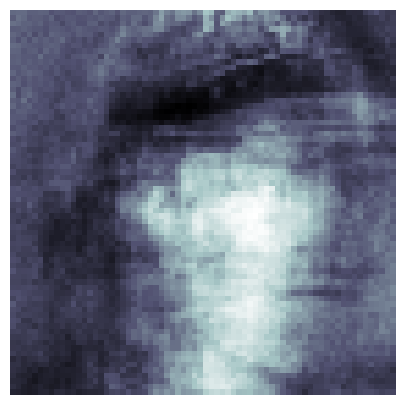

In [46]:
pl.imshow(model.predict(np.array([np_im_me.flatten()])).reshape(70,70),
          cmap="bone")
pl.axis('off');

# ... not good at all :-( why??

My picture is not formatted similarly to those in the training set. It is much closer and at a different angle and thus the model does not know how to accurately fill in the image.